In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.cluster import KMeans

In [ ]:
file1_path = "customer.csv"
file2_path = "product.csv"
file3_path = "store.csv"
file4_path = "transaction.csv"

df1 = pd.read_csv(file1_path)
df2 = pd.read_csv(file2_path)
df3 = pd.read_csv(file3_path)
df4 = pd.read_csv(file4_path)

In [ ]:
# Melihat tampilan data
df1.head()
df2.head()
df3.head()
df4.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [ ]:
# Tampilkan informasi tentang setiap DataFrame
df1.info()
df2.info()
df3.info()
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 17.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      ------------

## Identifikasi masalah dalam data:

In [ ]:
# Contoh mengidentifikasi nilai-nilai yang hilang pada setiap DataFrame
print(df1.isnull().sum())
print(df2.isnull().sum())
print(df3.isnull().sum())
print(df4.isnull().sum())

# Contoh mengidentifikasi nilai-nilai duplikat pada setiap DataFrame
print(df1.duplicated().sum())
print(df2.duplicated().sum())
print(df3.duplicated().sum())
print(df4.duplicated().sum())


CustomerID        0
Age               0
Gender            0
Marital Status    3
Income            0
dtype: int64
ProductID       0
Product Name    0
Price           0
dtype: int64
StoreID       0
StoreName     0
GroupStore    0
Type          0
Latitude      0
Longitude     0
dtype: int64
TransactionID    0
CustomerID       0
Date             0
ProductID        0
Price            0
Qty              0
TotalAmount      0
StoreID          0
dtype: int64
0
0
0
0


In [ ]:
# Mengatasi nilai yang hilang
df1.fillna(df1.mean(numeric_only=True), inplace=True)
df2.fillna(df2.median(numeric_only=True), inplace=True)
df3.fillna(df3.mean(numeric_only=True), inplace=True)
df4.fillna(df4.median(numeric_only=True), inplace=True)

In [ ]:
# Menghapus nilai duplikat:

df1.drop_duplicates(inplace=True)
df2.drop_duplicates(inplace=True)
df3.drop_duplicates(inplace=True)
df4.drop_duplicates(inplace=True)

## Merge Data

In [ ]:
# 1. Gabungkan tabel customer dan transaction berdasarkan kolom "CustomerID"
merged_customer_transaction = pd.merge(df1, df4, on="CustomerID", how="inner")

In [ ]:
# 2. Gabungkan hasil langkah 1 dengan tabel product berdasarkan kolom "ProductID"
merged_customer_transaction_product = pd.merge(merged_customer_transaction, df2, on="ProductID", how="inner")

In [ ]:
# 3. Gabungkan hasil langkah 2 dengan tabel store berdasarkan kolom "StoreID"
final_merged_data = pd.merge(merged_customer_transaction_product, df3, on="StoreID", how="inner")

In [ ]:
final_merged_data.to_csv("final_merged_data.csv", index=False)

## Machine Learning Regression (Time Series)

In [ ]:
# Konversi kolom "Date" menjadi tipe data datetime
final_merged_data["Date"] = pd.to_datetime(final_merged_data["Date"], format="%d/%m/%Y")

In [ ]:
# Kelompokkan data berdasarkan kolom "Date" dan lakukan agregasi dengan menjumlahkan nilai pada kolom "Qty"
regression_data = final_merged_data.groupby("Date")["Qty"].sum().reset_index()

In [ ]:
# Tampilkan data baru yang telah diagregasi untuk regresi
print(regression_data)

          Date  Qty
0   2022-01-01   49
1   2022-01-02   50
2   2022-01-03   76
3   2022-01-04   98
4   2022-01-05   67
..         ...  ...
360 2022-12-27   70
361 2022-12-28   68
362 2022-12-29   42
363 2022-12-30   44
364 2022-12-31   37

[365 rows x 2 columns]


## AIMA

In [ ]:
# Ubah kolom "Date" menjadi indeks
regression_data.set_index("Date", inplace=True)

In [ ]:
# Pastikan data diurutkan berdasarkan tanggal
regression_data.sort_index(inplace=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


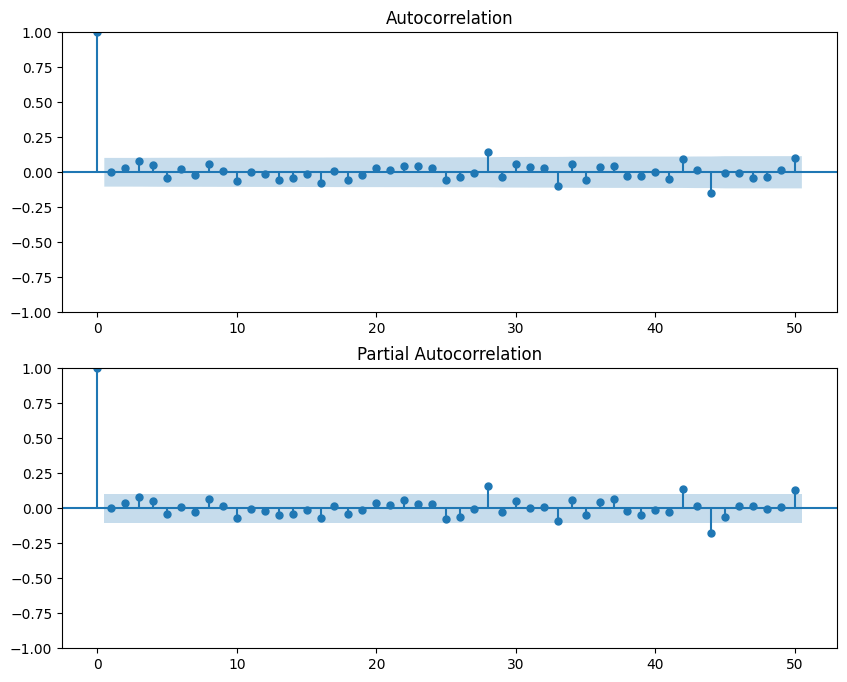

In [ ]:
# Pilih model ARIMA:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
sm.graphics.tsa.plot_acf(regression_data["Qty"], lags=50, ax=ax1)
sm.graphics.tsa.plot_pacf(regression_data["Qty"], lags=50, ax=ax2)
plt.show()

In [ ]:
# Fit model ARIMA:
p, d, q = 2, 1, 2
model = ARIMA(regression_data["Qty"], order=(p, d, q))
results = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
# Tampilkan ringkasan hasil model ARIMA
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                    Qty   No. Observations:                  365
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1542.751
Date:                Thu, 27 Jul 2023   AIC                           3095.502
Time:                        03:14:30   BIC                           3114.988
Sample:                    01-01-2022   HQIC                          3103.247
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9890      0.073    -13.521      0.000      -1.132      -0.846
ar.L2         -0.0030      0.055     -0.055      0.956      -0.111       0.105
ma.L1         -0.0046      0.052     -0.088      0.9

In [ ]:
# Melakukan prediksi:
# Misalnya, untuk melakukan prediksi 10 langkah ke depan
n_steps = 10
forecast = results.forecast(steps=n_steps)

# Tampilkan hasil prediksi
print(forecast)

2023-01-01    48.055551
2023-01-02    47.922019
2023-01-03    48.020703
2023-01-04    47.923510
2023-01-05    48.019333
2023-01-06    47.924860
2023-01-07    48.018003
2023-01-08    47.926172
2023-01-09    48.016709
2023-01-10    47.927448
Freq: D, Name: predicted_mean, dtype: float64


## Machine Learning Clustering

In [ ]:
# Kelompokkan data berdasarkan "CustomerID" dan lakukan agregasi
clustering_data = final_merged_data.groupby("CustomerID").agg({
    "TransactionID": "count",
    "Qty": "sum",
    "TotalAmount": "sum"
}).reset_index()

In [ ]:
# Ubah nama kolom hasil agregasi agar lebih jelas
clustering_data.columns = ["CustomerID", "TransactionCount", "TotalQty", "TotalAmount"]

In [ ]:
# Tampilkan data baru yang telah diagregasi untuk clustering
print(clustering_data)

     CustomerID  TransactionCount  TotalQty  TotalAmount
0             1                17        60       623300
1             2                13        57       392300
2             3                15        56       446200
3             4                10        46       302500
4             5                 7        27       268600
..          ...               ...       ...          ...
442         443                16        59       485100
443         444                18        62       577700
444         445                18        68       587200
445         446                11        42       423300
446         447                13        42       439300

[447 rows x 4 columns]


#### Menggunakan Metode Clustering KMeans:

In [ ]:
# Pilih kolom untuk clustering
X = clustering_data[["TransactionCount", "TotalQty", "TotalAmount"]]

In [ ]:
# Inisialisasi model KMeans dengan jumlah cluster yang diinginkan
num_clusters = 3
kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)

In [ ]:
# Melatih model dengan data
kmeans_model.fit(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

In [ ]:
# Menambahkan kolom "Cluster" pada DataFrame clustering_data untuk menyimpan hasil clustering
clustering_data["Cluster"] = kmeans_model.labels_

In [ ]:
# Tampilkan hasil clustering
print(clustering_data)

     CustomerID  TransactionCount  TotalQty  TotalAmount  Cluster
0             1                17        60       623300        2
1             2                13        57       392300        0
2             3                15        56       446200        0
3             4                10        46       302500        1
4             5                 7        27       268600        1
..          ...               ...       ...          ...      ...
442         443                16        59       485100        2
443         444                18        62       577700        2
444         445                18        68       587200        2
445         446                11        42       423300        0
446         447                13        42       439300        0

[447 rows x 5 columns]


#### Visualisasi Hasil Clustering:

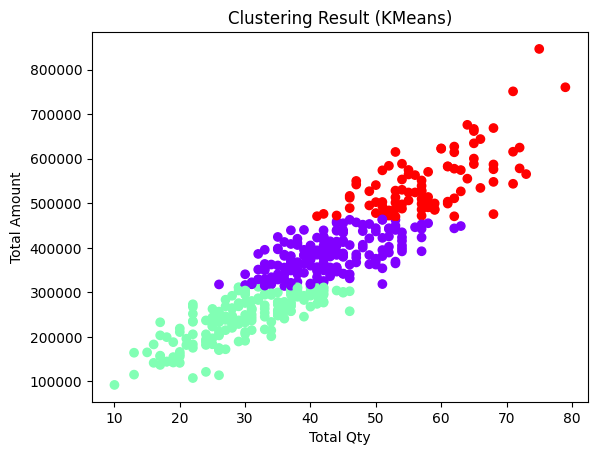

In [ ]:
plt.scatter(clustering_data["TotalQty"], clustering_data["TotalAmount"], c=clustering_data["Cluster"], cmap='rainbow')
plt.xlabel("Total Qty")
plt.ylabel("Total Amount")
plt.title("Clustering Result (KMeans)")
plt.show()
